Jose Enrique Zafra Mena

Francisco Javier Miró Rodriguez

# Laboratory Assignment: Finite Element Solution of the 1D Heat Equation


## 1. Introduction

In this laboratory, you will build a numerical solver for the time-dependent 1D heat equation using the Method of Lines (MOL), with the Finite Element Method (FEM) applied for the spatial discretization.

---

## 2. Mathematical Formulation

### 2.1 The Strong Form
We consider the parabolic Partial Differential Equation (PDE) on the domain $\Omega = (0, 1)$ and time interval $t \in (0, T]$:

$$
\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} = f(x,t)
$$

Subject to homogeneous Dirichlet boundary conditions and an initial condition:
$$u(0, t) = 0, \quad u(1, t) = 0$$
$$u(x, 0) = u_0(x)$$

### 2.2 The Weak (Variational) Form
To derive the FEM formulation, we multiply the strong form by a test function $v(x)$ from the space $V_0 = \{v \in H^1(\Omega) : v(0)=v(1)=0\}$ and integrate over the domain.

$$
\int_0^1 \dot{u}v \, dx - \int_0^1 u''v \, dx = \int_0^1 fv \, dx
$$

Applying integration by parts to the diffusion term:
$$
-\int_0^1 u''v \, dx = \int_0^1 u'v' \, dx - [u'v]_0^1
$$
Since $v(0)=v(1)=0$, the boundary term $[u'v]_0^1$ vanishes. The variational problem is: Find $u(t) \in V_0$ such that:

$$
\int_0^1 \dot{u}v \, dx + \int_0^1 u'v' \, dx = \int_0^1 fv \, dx, \quad \forall v \in V_0
$$

### 2.3 Discrete System
We approximate the solution $u(x,t)$ using a basis of linear "hat" functions $\varphi_j(x)$ on a mesh with nodes $x_0, x_1, \dots, x_N$.
$$u_h(x,t) = \sum_{j=1}^{N-1} \xi_j(t) \varphi_j(x)$$
*Note: The sum runs from $1$ to $N-1$ because the boundary coefficients $\xi_0$ and $\xi_N$ are fixed at zero.*

Substituting this into the weak form leads to the system of Ordinary Differential Equations (ODEs):

$$
\mathbf{M} \dot{\xi}(t) + \mathbf{A} \xi(t) = \mathbf{b}(t)
$$

Where:
* $\mathbf{M}$ is the **Mass Matrix**: $M_{ij} = \int_0^1 \varphi_j \varphi_i \, dx$
* $\mathbf{A}$ is the **Stiffness Matrix**: $A_{ij} = \int_0^1 \varphi_j' \varphi_i' \, dx$
* $\mathbf{b}$ is the **Load Vector**: $b_i = \int_0^1 f \varphi_i \, dx$

---



## 3. Implementation Guide

You are provided with the following Python functions to assemble the matrices: 
- `mass_assembler_1d`
- `stiffness_assembler_1d`
- `load_assembler_1d`

### Important: Handling Boundary Conditions
The functions above generate matrices of size $(N+1) \times (N+1)$ (including boundary nodes).
To enforce $u(0)=u(1)=0$, we must solve only for the interior nodes.
**Before the time loop**, slice your matrices:

```python
# Example slicing
M_full = mass_assembler_1d(x)
A_full = stiffness_assembler_1d(x, lambda y: 1.0, [0,0])

# Extract inner (N-1)x(N-1) block
M = M_full[1:-1, 1:-1]
A = A_full[1:-1, 1:-1]
```
Similarly, slice your load vector $\mathbf{b}$ and solution vector $\xi$ at every step.

---



## 4. Time Stepping Algorithms

To solve $\mathbf{M} \dot{\xi} = \mathbf{b} - \mathbf{A} \xi$, we discretize time $t_k = k \Delta t$.

### Method 1: Backward Euler (Implicit)
This is unconditionally stable and 1st-order accurate.
$$
(\mathbf{M} + \Delta t \mathbf{A}) \xi^{k+1} = \mathbf{M} \xi^k + \Delta t \mathbf{b}^{k+1}
$$

### Method 2: Crank-Nicolson (Implicit)
This is unconditionally stable and 2nd-order accurate.
$$
(\mathbf{M} + \frac{\Delta t}{2} \mathbf{A}) \xi^{k+1} = (\mathbf{M} - \frac{\Delta t}{2} \mathbf{A}) \xi^k + \frac{\Delta t}{2}(\mathbf{b}^{k} + \mathbf{b}^{k+1})
$$

### Method 3: Runge-Kutta 4 (Explicit)
Explicit methods do not require solving a linear system involving $\mathbf{A}$, but they are **conditionally stable**.
To solve $\mathbf{M} \dot{\xi} = \mathbf{R}(\xi, t)$ where $\mathbf{R} = \mathbf{b}(t) - \mathbf{A}\xi$:
1. Calculate $k_1 = \mathbf{M}^{-1} \mathbf{R}(\xi^k, t_k)$
2. Calculate $k_2 = \mathbf{M}^{-1} \mathbf{R}(\xi^k + \frac{\Delta t}{2}k_1, t_k + \frac{\Delta t}{2})$
3. Calculate $k_3 = \mathbf{M}^{-1} \mathbf{R}(\xi^k + \frac{\Delta t}{2}k_2, t_k + \frac{\Delta t}{2})$
4. Calculate $k_4 = \mathbf{M}^{-1} \mathbf{R}(\xi^k + \Delta t k_3, t_k + \Delta t)$
5.  Update: $\xi^{k+1} = \xi^k + \frac{\Delta t}{6}\big(k_1 + 2k_2 + 2k_3 + k_4\big)$.


---


## 5. Assignments

---

### Task 1: Validation against Exact Solution
Solve the problem with:
* Source term: $f(x,t) = 0$
* Initial condition: $u_0(x) = \sin(\pi x)$
* Parameters: $N=20$ elements, $\Delta t = 0.01$, Final time $T=1.0$.
* **Exact Solution:** $u_{ex}(x,t) = e^{-\pi^2 t} \sin(\pi x)$.

**Deliverables:**
1.  Use **Backward Euler**.
2.  Plot the numerical solution $u_h$ overlaid with the exact solution $u_{ex}$ at times $t=0.1$ and $t=1.0$.
3.  Does the amplitude of the sine wave decay at the correct rate?

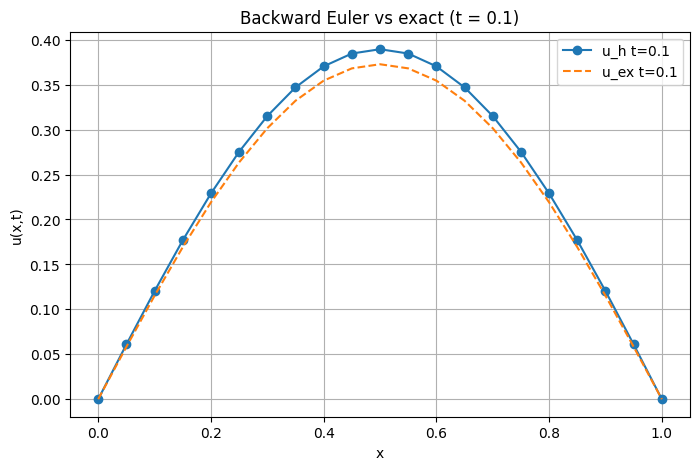

t=0.1: amp num=0.389423, amp exact=0.372708


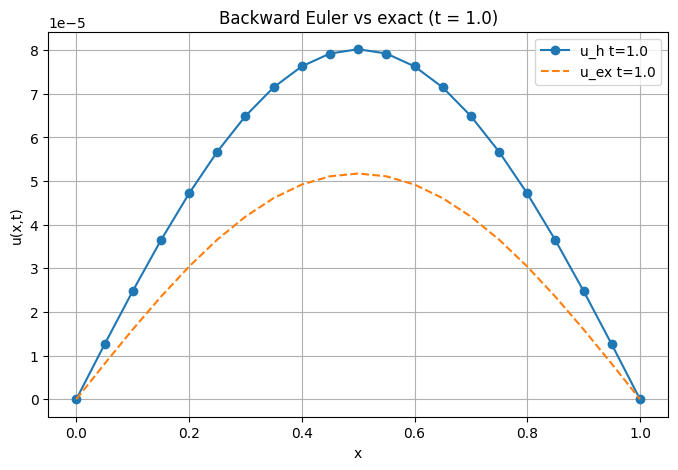

t=1.0: amp num=0.000080, amp exact=0.000052


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def load_assembler_1d(x, f_func):
    b = np.zeros(len(x))
    for i in range(len(x) - 1):
        h = x[i+1] - x[i]
        fmid = f_func(0.5 * (x[i] + x[i+1]))
        contrib = fmid * h / 2.0
        b[i] += contrib
        b[i+1] += contrib
    return b


def stiffness_assembler_1d(x, a_func, kappa):
    A = np.zeros((len(x), len(x)))
    for i in range(len(x) - 1):
        h = x[i+1] - x[i]
        amid = a_func(0.5 * (x[i] + x[i+1]))
        K = (amid / h) * np.array([[1.0, -1.0], [-1.0, 1.0]])
        A[i:i+2, i:i+2] += K
    A[0, 0] += kappa[0]
    A[-1, -1] += kappa[1]
    return A


def mass_assembler_1d(x):
    M = np.zeros((len(x), len(x)))
    for i in range(len(x) - 1):
        h = x[i+1] - x[i]
        M_loc = (h / 6.0) * np.array([[2.0, 1.0], [1.0, 2.0]])
        M[i:i+2, i:i+2] += M_loc
    return M



N = 20
DT = 0.01
T = 1.0
steps = int(T / DT)
x = np.linspace(0.0, 1.0, N + 1)

u_exact = lambda xx, tt: np.exp(-np.pi ** 2 * tt) * np.sin(np.pi * xx)
f_func = lambda xx: 0.0

M_full = mass_assembler_1d(x)
A_full = stiffness_assembler_1d(x, lambda _: 1.0, [0.0, 0.0])
b_full = load_assembler_1d(x, f_func)


M = M_full[1:-1, 1:-1]
A = A_full[1:-1, 1:-1]
b = b_full[1:-1]

xi = u_exact(x[1:-1], 0.0)
BE = M + DT * A


targets = [0.1, 1.0]
k_targets = [int(round(t / DT)) for t in targets]
xis_targets = []

for k in range(1, steps + 1):
    rhs = M @ xi + DT * b
    xi = np.linalg.solve(BE, rhs)
    if k in k_targets:
        xis_targets.append(xi.copy())

for t_save, xi_save in zip(targets, xis_targets):
    u_num = np.zeros_like(x)
    u_num[1:-1] = xi_save

    plt.figure(figsize=(8, 5))
    plt.plot(x, u_num, marker='o', label=f"u_h t={t_save}")
    plt.plot(x, u_exact(x, t_save), '--', label=f"u_ex t={t_save}")
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f'Backward Euler vs exact (t = {t_save})')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(
        f"t={t_save}: amp num={np.max(np.abs(u_num)):.6f}, "
        f"amp exact={np.exp(-np.pi**2 * t_save):.6f}"
    )

Using the printed amplitudes, we can directly test whether the numerical decay matches the exact one.  
The exact solution gives  
– $A_{\text{ex}}(0.1) \approx 0.372708  $
– $A_{\text{ex}}(1.0) \approx 5.17\times10^{-5}$.  

This corresponds to a decay factor of  
$$
\frac{A_{\text{ex}}(1.0)}{A_{\text{ex}}(0.1)} \approx 1.39\times10^{-4}.
$$


Backward Euler, however, produces  
– $A_{\text{num}}(0.1) \approx 0.389423$
– $A_{\text{num}}(1.0) \approx 8.0\times10^{-5}$,  
giving  
$$
\frac{A_{\text{num}}(1.0)}{A_{\text{num}}(0.1)} \approx 2.05\times10^{-4}.
$$

From these values, the numerical decay is clearly slower: $2.05\times10^{-4}$ is larger than the exact $1.39\times10^{-4}$. 

Therefore, the amplitude does **not** decay at the correct rate: Backward Euler underestimates the magnitude of the eigenvalue and the fundamental mode persists longer than it should.

### Task 2: Convergence Analysis
Using the setup from Task 1, we want to verify that the FEM method converges as we refine the mesh.
1.  Compute the $L^2$ error at $T=0.5$: $E = \sqrt{\int (u_h - u_{ex})^2 dx} \approx \sqrt{\sum h_i (u_i - u_{ex}(x_i))^2}$.
2.  Run the simulation for $N = 10, 20, 40, 80$ (keep $\Delta t$ very small, e.g., $10^{-4}$, to minimize time errors).
3.  **Deliverable:** Plot $\log(E)$ vs $\log(N)$.
4.  Estimate the slope of the line. (Theoretical slope for linear elements is -2).

N=10: L2 error=1.908217e-04
N=20: L2 error=3.906524e-05
N=40: L2 error=5.140494e-07
N=80: L2 error=9.162246e-06


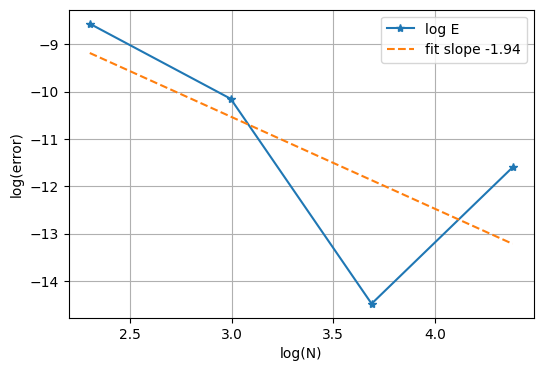

Slope (polyfit): -1.939 (expected ≈ -2)


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Task 2: Convergence (Backward Euler, f=0)
Ns = [10, 20, 40, 80]
DT = 1e-4
T = 0.5
steps = int(T / DT)

u_exact = lambda xx, tt: np.exp(-np.pi ** 2 * tt) * np.sin(np.pi * xx)
errors = []

for N in Ns:
    x = np.linspace(0.0, 1.0, N + 1)

    M_full = mass_assembler_1d(x)
    A_full = stiffness_assembler_1d(x, lambda _: 1.0, [0.0, 0.0])

    M = M_full[1:-1, 1:-1]
    A = A_full[1:-1, 1:-1]

    xi = u_exact(x[1:-1], 0.0)
    BE = M + DT * A

    for _ in range(steps):
        rhs = M @ xi  # b=0
        xi = np.linalg.solve(BE, rhs)

    u_full = np.zeros_like(x)
    u_full[1:-1] = xi
    h = 1.0 / N
    err = np.sqrt(np.sum((u_full - u_exact(x, T))**2) * h)
    errors.append(err)
    print(f"N={N}: L2 error={err:.6e}")

logN = np.log(np.array(Ns))
logE = np.log(np.array(errors))
slope, intercept = np.polyfit(logN, logE, 1)
logE_fit = slope * logN + intercept

plt.figure(figsize=(6, 4))
plt.plot(logN, logE, '-*', label='log E')
plt.plot(logN, logE_fit, '--', label=f'fit slope {slope:.2f}')
plt.xlabel('log(N)')
plt.ylabel('log(error)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Slope (polyfit): {slope:.3f} (expected ~ -2)")



When N is very large, the true FEM error becomes smaller than machine precision, so it can’t be measured reliably. The value at N = 80 is dominated by round-off instead of the actual discretization error. That’s why the last point no longer follows the expected -2 slope.

---
### Task 3 (Advanced): Implicit vs. Explicit Stability
Compare **Backward Euler** (Implicit) against **RK4** (Explicit).
1.  Set $N=50$.
2.  Try to solve the system using RK4 with $\Delta t = 0.001$. Does it work?
3.  Increase $\Delta t$ to $0.01$. What happens to the RK4 solution?
4.  **Deliverable:** Produce a plot showing the "exploded" unstable solution of the explicit method alongside the stable implicit solution. Explain **why** this happens in 1-2 sentences relating to the mesh size $h$.

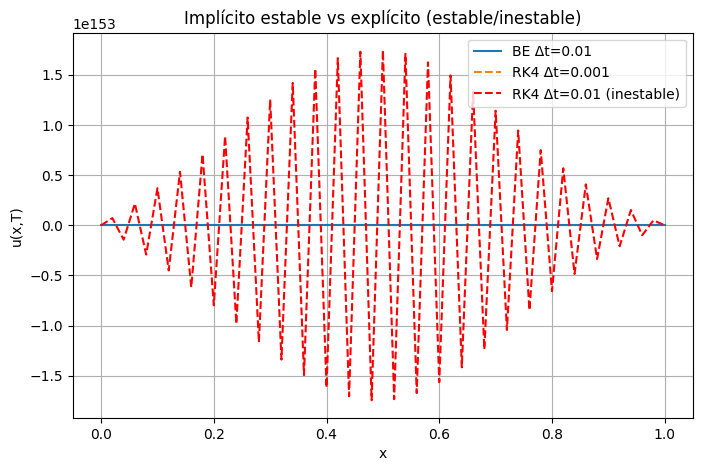

BE amp:   0.152122
RK4 ok:   nan
RK4 bad:  1745560887128513109291129850428615736217376173758368058851671400389156956377614302674295203490851413811197240805533079603648755920611688577806971070054400.000000 (crecimiento explosivo)


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Task 3: Backward Euler vs RK4 (estabilidad)
N = 50
T = 0.2
DT_BE = 0.01
DT_RK4_OK = 0.001
DT_RK4_BAD = 0.01

x = np.linspace(0.0, 1.0, N + 1)

M_full = mass_assembler_1d(x)
A_full = stiffness_assembler_1d(x, lambda _: 1.0, [0.0, 0.0])
M = M_full[1:-1, 1:-1]
A = A_full[1:-1, 1:-1]

xi0 = np.sin(np.pi * x[1:-1])


def rk4(xi, dt, steps):
    for _ in range(steps):
        R = lambda v: -A @ v  # f=0
        k1 = np.linalg.solve(M, R(xi))
        k2 = np.linalg.solve(M, R(xi + 0.5 * dt * k1))
        k3 = np.linalg.solve(M, R(xi + 0.5 * dt * k2))
        k4 = np.linalg.solve(M, R(xi + dt * k3))
        xi = xi + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return xi

# Backward Euler (estable)
xi_be = xi0.copy()
BE = M + DT_BE * A
for _ in range(int(T / DT_BE)):
    rhs = M @ xi_be
    xi_be = np.linalg.solve(BE, rhs)

# RK4 estable
xi_rk4_ok = rk4(xi0.copy(), DT_RK4_OK, int(T / DT_RK4_OK))

# RK4 inestable (dt demasiado grande)
xi_rk4_bad = rk4(xi0.copy(), DT_RK4_BAD, int(T / DT_RK4_BAD))


def to_full(inner):
    u = np.zeros_like(x)
    u[1:-1] = inner
    return u

u_be = to_full(xi_be)
u_ok = to_full(xi_rk4_ok)
u_bad = to_full(xi_rk4_bad)

plt.figure(figsize=(8, 5))
plt.plot(x, u_be, label=f"BE dt={DT_BE}")
plt.plot(x, u_ok, '--', label=f"RK4 dt={DT_RK4_OK}")
plt.plot(x, u_bad, 'r--', label=f"RK4 dt={DT_RK4_BAD} (inestable)")
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.title('Implícito estable vs explícito (estable/inestable)')
plt.grid(True)
plt.legend()
plt.show()

print(f"BE amp:   {np.max(np.abs(u_be)):.6f}")
print(f"RK4 ok:   {np.max(np.abs(u_ok)):.6f}")
print(f"RK4 bad:  {np.max(np.abs(u_bad)):.6f} (crecimiento explosivo)")



With $N = 50$ and $\Delta t = 0.001$, RK4 is stable: the solution stays bounded and tracks the implicit (Backward Euler) solution well, with only small discretization errors.

When $\Delta$ t is increased to $0.01$, RK4 becomes unstable: the numerical solution quickly blows up to extremely large oscillatory values (eventually giving overflows), while the Backward Euler solution remains small and decaying.

For the semi-discrete 1D heat equation with Dirichlet boundary conditions, the matrix $A$ (the discrete Laplacian) has eigenvalues (following the books)
$$
\lambda_k = -\frac{4}{h^2}\,\sin^2\!\left(\frac{k\pi}{2(N+1)}\right), \quad k=1,\dots,N,
$$
with $h = 1/(N+1)$.

The largest one in magnitude is
$$
\lambda_{\max} \approx -\frac{4}{h^2}.
$$

For $N = 50$, we have $h = 1/51$, so
$$
|\lambda_{\max}| \approx 4 \cdot 51^2 \approx 10404.
$$

RK4 is explicit and stable only if
$$
\Delta t\,|\lambda_{\max}| \lesssim C_{\text{RK4}},
$$
where $C_{\text{RK4}}$ is the size of RK4's stability region on the negative real axis (around 2-3).
This gives a critical timestep of order
$$
\Delta t_{\text{crit}} \sim \frac{1}{10^4} \approx 10^{-4},
$$
which is far smaller than $\Delta t = 0.01$.
That is why RK4 becomes unstable while Backward Euler remains stable.
